Geographic Visualization of COVID-19 Data
-------------------------------------------------------------------------------------------------------------------------------

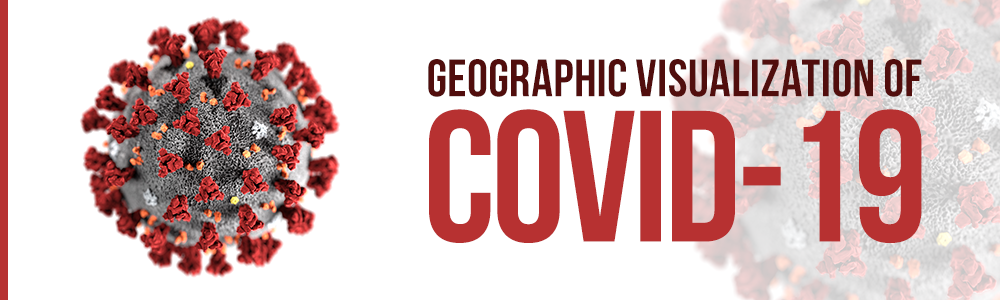

### Table of Contents:

1. [Introduction.](#bullet-1)
2. [Import required libraries.](#bullet-2)
3. [Specify data source url address.](#bullet-3)
4. [Define functions to be used in the project.](#bullet-4)<br>
    4a. [Data Request Function.](#bullet-5)<br>
    4b. [Data Cleaning Functions.](#bullet-6)<br>
    4c. [Data Geolocation Function.](#bullet-7)<br>
    4d. [Data Geovisualization Function.](#bullet-8)<br>
    4e. [Main Function.](#bullet-9)
5. [Run the entire project.](#bullet-10)
6. [BONUS step.](#bullet-11)

### 1: Introduction. <a class="anchor" id="bullet-1"></a>

It is no longer news that visualization of data gives deeper insights and helps understand the trend of a particular observation. Also, it makes data analysis easier has the entire dataset can be presented in a single page.

Due to the ongoing COVID-19 pandemic, I decided to create a geographic visualization on the available data from a statistics website, which details the number of cases, number of deaths, number of active cases, etc, per country. This visualization uses geographic location for each country and displays the essential data as listed above when hovered on.
 
This notebook shows the steps involved from data extraction, data cleaning, creation of coordinates, and visualization on a map.

### 2: Import required libraries. <a class="anchor" id="bullet-2"></a>

Import the required libraries for the data extraction, cleaning and visualization stages.

In [ ]:
import numpy as np
import pandas as pd
import requests
import IPython
from IPython.display import display

import geopy
from geopy.geocoders import Nominatim
import geoviews as gv
import geoviews.tile_sources as gvts
from geoviews import opts
import bokeh
from bokeh.models import HoverTool

gv.extension('bokeh', 'matplotlib')

In [ ]:
print('numpy==',np.__version__)
print('pandas==',pd.__version__)
print('requests==',requests.__version__)
print('IPython==',IPython.__version__)
print('geopy==',geopy.__version__)
print('geoviews==',gv.__version__)
print('bokeh==',bokeh.__version__)

### 3: Specify data source url address. <a class="anchor" id="bullet-3"></a>

For this project, we will be focusing on the most visited website for COVID-19 resources based on https://www.similarweb.com/coronavirus#keywords-and-websites.
<br>
A recent statistics shown below;
     
   1. <a href="https://www.worldometers.info/coronavirus/" target="_blank">Worldometers</a> with 31.4 million visits on 04/22/2020.
   2. <a href="https://cdc.gov/" target="_blank">Centers for Disease Control & Prevention</a> with 5.5 million visits on 04/22/2020.
   3. <a href="https://who.int/" target="_blank">World Health Organization</a> with 4.1 million visits on 04/22/2020.
   4. <a href="https://ecdc.europa.eu/" target="_blank">European Centre for Disease Prevention & Control</a> with 170k visits on 04/22/2020.

In [ ]:
COVID_19_URL = 'https://www.worldometers.info/coronavirus/'

### 4: Define functions to be used in the project. <a class="anchor" id="bullet-4"></a>

We are going to be defining functions for data requests/extracts, data cleaning, data geolocation, and the eventual data 
visualization.

#### 4a: Data Request Function: <a class="anchor" id="bullet-5"></a>

In [ ]:
def data_request(url):
    '''
    This function requests content from the specified url and extracts the data table into a dataframe.
    '''
    
    try:
        html_request = requests.get(url, headers={'Cache-Control': 'no-cache', 'Pragma': 'no-cache'})
    except Exception as e:
        raise e
    
    html = html_request.content
    table = pd.read_html(html)[-1]
    
    return table

#### 4b: Data Cleaning Functions: <a class="anchor" id="bullet-6"></a>

In [ ]:
def data_cleaner(table):
    '''
    This function serves to rid the dataframe of incorrect country names, total/sum values of the columns, and NaN values.
    '''
    
    #Drop the world and total rows. Upon intial checking, they were identified as rows 213 and 0 respectively.
    table = table.drop([213, 0])
    unneededColumns = range(7, 12)
    edited_table = table.drop(table.columns[unneededColumns], axis = 1)
    
    
    #replace NaN values with zeros
    corrected_table = edited_table.fillna(0)
    
    
    #modify the country names
    old_values = ['CAR', 'Georgia', 'UAE']
    new_values = ['Central African Republic', 'Republic of Georgia', 'United Arab Emirates']
    corrected_country = corrected_table.replace(old_values, new_values)
    corrected_table = corrected_country.sort_values(by = ['Country,Other'])

    final_table = corrected_table.rename(columns={
        'Country,Other' : 'Country', 'TotalCases': 'Total Cases', 'TotalDeaths': 'Total Deaths', 
        'NewCases': 'New Cases', 'NewDeaths': 'New Deaths', 'TotalRecovered': 'Total Recovered',
        'ActiveCases': 'Active Cases'})
    
    
    #convert specific columns t lists
    country_list = final_table['Country'].to_list()
    new_cases_list = final_table['New Cases'].to_list()
    new_deaths_list = final_table['New Deaths'].to_list()
    
    #preview the table and lists
    #print(country_list, '\n')
    #print(new_cases_list, '\n')
    #print(new_deaths_list, '\n')
    
    
    return final_table, country_list, new_cases_list, new_deaths_list

In [ ]:
def remove_signs(signedList):
    '''
    This step involves modification of the row values of the New Cases and New Deaths.
    Upon printing the top 5 rows using .heads() attribute of the pandas library, we notice '+' and ',' signs in the values.
    As such, we need to modify these values to show just numbers or integers.
    '''
    #print(signedList, '\n')
    
    unsignedList = []
    
    for each in signedList:
        if type(each) == str:
            each = each.replace(',', '')
            new = int(each[1:])
        else:
            new = each
        unsignedList.append(new)
    
    #print(unsignedList, '\n')
    
    return unsignedList

#### 4c Data Geolocation Function: <a class="anchor" id="bullet-7"></a>

In [ ]:
def location(country_list):
    '''
    This step involves creating/extracting the respective geographic locations of the COVID-19 data extracted in step 2.
    This geographic locations, in terms of longitude and latitude, are appended to the final_table dataframe from the
    second step.
    '''
    
    geolocator = Nominatim(user_agent = 'Chrome/80.0.3987.132')

    longitude_list = []
    latitude_list = []

    for each in country_list:
        location = geolocator.geocode(each, timeout = 15)
    
        log = location.longitude
        lat = location.latitude 
        
        longitude_list.append(log)
        latitude_list.append(lat)
 
    return latitude_list, longitude_list

#### 4d: Data Geovisualization Function: <a class="anchor" id="bullet-8"></a>

In [ ]:
def plot_geomap(final_table):
    '''
    This step involves creating the geographic visualization using a real-time dataset that gets daily updates.
    '''
    
    #plot the datapoints on the respective geolocations.
    table_plot = gv.Points(final_table, ['Longitude', 'Latitude'], ['Country', 'Total Cases', 'Total Deaths',
                               'New Cases', 'New Deaths', 'Total Recovered', 'Active Cases'])

    
    #create the hover tools to be shown if datapoint is selected on the map.
    tooltips = [('Country', '@Country'), ('Total Cases', '@Total Cases'),
            ('Total Deaths', '@Total Deaths'), ('New Cases', '@New Cases'),
            ('New Deaths', '$New Deaths'), ('Total Recovered', '$Total Recovered'),\
            ('Active Cases', '$Active Cases')]

    HoverTool(tooltips = tooltips)

    
    #plot the map visualization including the hover tool
    covid_plot = (gvts.CartoDark * table_plot).opts(
        opts.Points(global_extent=True, width=900, height=600, alpha=0.8, hover_line_color='black',\
                line_color='black', xaxis=None, yaxis=None, tools=['hover'], size = 10,\
                color='red', hover_fill_color='green', hover_fill_alpha=0.8, toolbar='above'))

    
    return covid_plot

#### 4e: Main Function: <a class="anchor" id="bullet-9"></a>

In [ ]:
def main():
    '''
    A combination of all the created functions to visualize the geographical map of COVID-19 data.
    '''
    #request and clean data
    data_table = data_request(url=COVID_19_URL)
    
    data = data_cleaner(data_table)
    
    #assign data output to lists and dataframe
    final_table = data[0]
    lat_long = location(data[1])
    new_cases_list = remove_signs(data[2])
    new_deaths_list = remove_signs(data[3])
    
    #append lists to the dataframe
    final_table['Latitude'] = lat_long[0]
    final_table['Longitude'] = lat_long[1]
    final_table['New Cases'] = new_cases_list
    final_table['New Deaths'] = new_deaths_list
    
    
    
    #plot visualization
    plot = plot_geomap(final_table)
    display(plot)

### 5: Run the entire project. <a class="anchor" id="bullet-10"></a>

This step runs the main function, executes the already defined functions.

In [ ]:
if __name__ == '__main__':
    main()

### 6: BONUS step. <a class="anchor" id="bullet-11"></a>

The step involves exporting the final_table to a CSV file for future reference, if required.

In [ ]:
data_table = data_request(url=COVID_19_URL)    
data = data_cleaner(data_table)
final_table = data_cleaner(data_table)[0]

#display top 5 countries
display(final_table.sort_values(by = ['Total Cases'], ascending = False).head())

#display bottom 5 countries
display(final_table.sort_values(by = ['Total Cases'], ascending = False).tail())

if True:
    final_table.sort_values(by = ['Total Cases'], ascending = False).to_csv('corona_virus_data_extract.csv')
    print('\nCOVID-19 data successfully saved as CSV file.')